# Q-Learning with and without an Experience Replay Buffer

In the following notebook, we show implementations of the off-policy RL algorithm *Q-Learning* using deep neural networks parametrization for the q-function, $Q(s, a)$, together with an $\epsilon$-greedy policy scheme. The details of the algorithm are described in the figure below, borrowed from the Introduction to RL book by Sutton & Barto [1]. We deviate from the original algorithm only in our usage of a neural network instead of a tabular q-function. In addition, we compare the original algorithm (which uses an online update scheme) to a one with an *Experience Replay Buffer*, which makes its update scheme, somewhat offline. More details on the Experience Replay Buffer concept, can be found in [2], which is the source of the method, and in [3], with a much simpler take on the matter, while less detailed.

We use the *Acrobot-v1* environment illustrated below, borrowed from the [Acrobot Gymnasium webpage](https://gymnasium.farama.org/environments/classic_control/acrobot/)

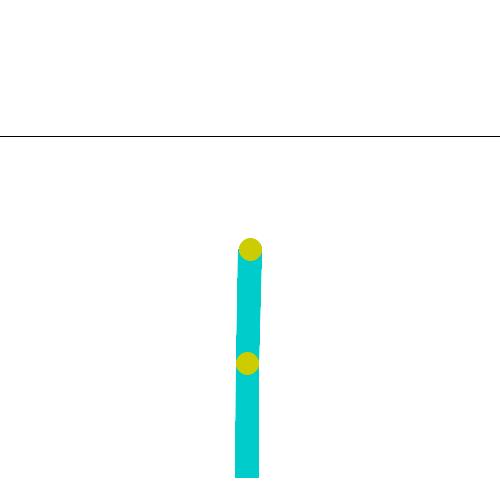

So, let's begin.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import gymnasium as gym

In [6]:
# define a dictionary for saving results
results_data_dict = {}

Adding a few utility functions for plotting.

In [7]:
def plot_results(avg_scores, std_scores, name=None):
    # set title name
    if name is not None:
        title_name = f"Score averaged over different experiments ({name})"
    else:
        title_name = f"Score averaged over different experiments"
    
    # plot the results from a set of experiments
    n_episodes = len(avg_scores[0])
    n_experiments = len(avg_scores)

    avg_scores = np.array(avg_scores)
    avg_avg_scores = np.mean(avg_scores, axis=0)
    std_avg_scores = np.std(avg_scores, axis=0)

    upper_std_scores = avg_avg_scores + std_avg_scores
    lower_std_scores = avg_avg_scores - std_avg_scores
    x = range(1, n_episodes + 1)

    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(11, 6), sharex=True)
    
    ax[0].set_title(title_name)
    ax[0].plot(x, avg_avg_scores, label=f'average score')
    ax[0].fill_between(x, upper_std_scores, lower_std_scores, 
                    where=(upper_std_scores > lower_std_scores), alpha=0.3)

    for i in range(n_experiments):
        avg_scores_numpy = np.array(avg_scores[i])
        std_scores_numpy = np.array(std_scores[i])
        upper = avg_scores_numpy + std_scores_numpy
        lower = avg_scores_numpy - std_scores_numpy
        ax[1].plot(x, avg_scores_numpy, label=f'Exp-{i}')
        ax[1].fill_between(x, upper, lower, where=(upper > lower), alpha=0.3)

    ax[1].set_xlabel('episode')
    ax[0].set_ylabel('score')
    ax[1].set_ylabel('score')
    ax[0].legend()
    ax[0].grid()
    ax[1].legend()
    ax[1].grid()
    plt.show()
    
def compare_results(data_dict):
    """
    Compare the results from different experiments
    :param: data_dict = {name1: [avg_scores1, std_scores1], 
                         name2: [avg_scores2, std_scores2],
                         ...
                         nameN: [avg_scoresN, std_scoresN],}
    """
    
    # plot the results from a set of experiments
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 6))
    ax.set_title("Comparison of different RL algorithms' averaged score over a set of experiments")
    
    for item in data_dict:
        name = item
        avg_scores, std_scores = data_dict[name]
        
        n_episodes = len(avg_scores[0])
        n_experiments = len(avg_scores)

        avg_scores = np.array(avg_scores)
        avg_avg_scores = np.mean(avg_scores, axis=0)
        std_avg_scores = np.std(avg_scores, axis=0)

        upper_std_scores = avg_avg_scores + std_avg_scores
        lower_std_scores = avg_avg_scores - std_avg_scores
        x = range(1, n_episodes + 1)


        ax.plot(x, avg_avg_scores, label=f'{name} agent')
        ax.fill_between(x, upper_std_scores, lower_std_scores, 
                        where=(upper_std_scores > lower_std_scores), alpha=0.3)


    ax.set_ylabel('score')
    ax.legend()
    ax.grid()
    plt.show()

# Q-Learning without a Replay Buffer

Below is the complete Q-Learning algorithm for the tabular case. We will use a neural network instead of a tabular Q-function.

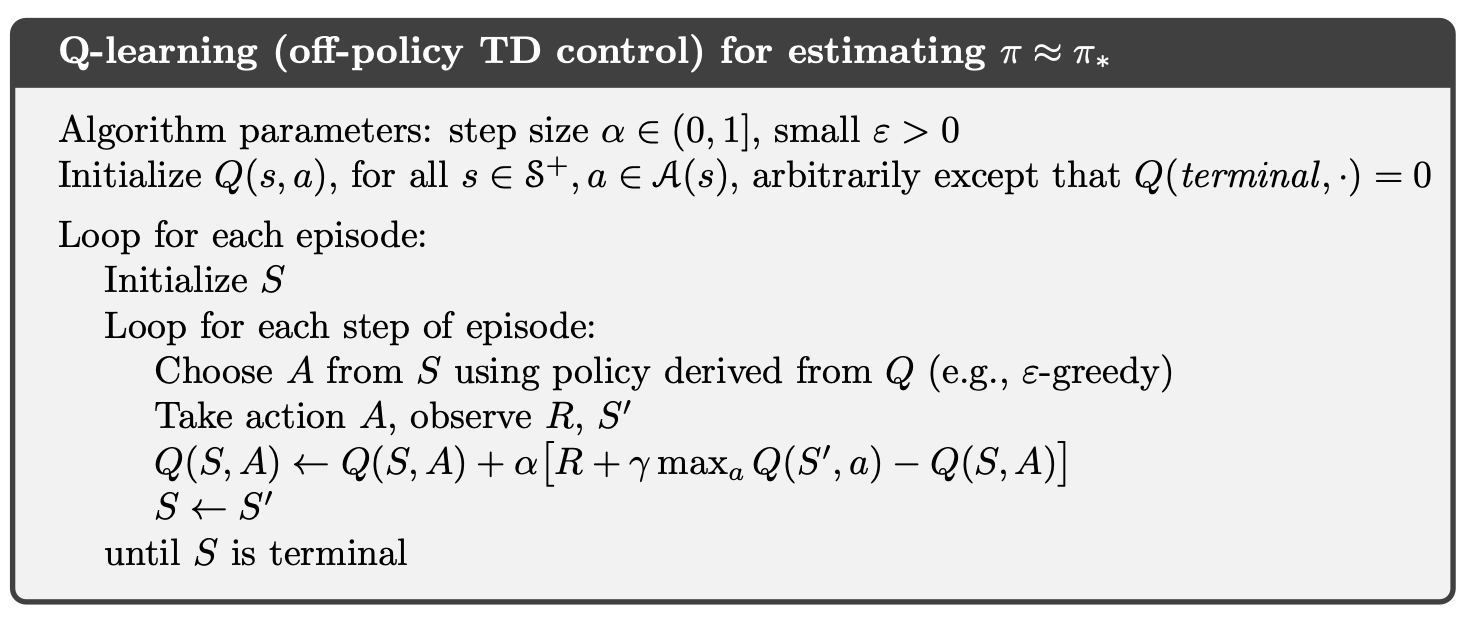

We begin with writing the neural network for the Q-function, which is just a Multi-Layer Perceptron (MLP) with three layers.  

In [8]:
class QNetwork(nn.Module):
    def __init__(self, observation_dim, action_dim, learning_rate):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(in_features=observation_dim, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=256)
        self.output_layer = nn.Linear(in_features=256, out_features=action_dim)
    
        self.optimizer = T.optim.Adam(params=self.parameters(), lr=learning_rate)
        self.device = ("cuda:0" if T.cuda.is_available() else "cpu")
        self.to(self.device)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.output_layer(x)
        return x

Then, we write the Q-Learning agent class, utilizing an $\epsilon$-greedy policy scheme.

In [15]:
class QLearningAgent:
    def __init__(self, observation_dim, action_dim, n_actions, 
                 learning_rate, gamma, epsilon, epsilon_dec, epsilon_min):
        super(QLearningAgent, self).__init__()
        self.observation_dim = observation_dim
        self.action_dim = action_dim
        self.n_actions = n_actions
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_dec = epsilon_dec
        self.epsilon_min = epsilon_min
        self.learning_steps = 0
        
        # initialize a q network
        self.q = QNetwork(observation_dim, action_dim, learning_rate)
        
    def choose_action(self, observation, evaluate=False):
        observation = T.from_numpy(observation).float().to(self.q.device)
        if evaluate:
            q_values = self.q(observation)
            action = T.argmax(q_values).item()
        else:
            if np.random.rand() < self.epsilon:
                action = np.random.randint(low=0, high=self.n_actions, size=1)[0]
            else:
                q_values = self.q(observation)
                action = T.argmax(q_values).item()
        return action
                
    
    def decrement_epsilon(self):
        self.epsilon = np.max([self.epsilon - self.epsilon_dec, self.epsilon_min])
    
    def learn(self, observation, action, reward, next_observation, terminated):
        self.learning_steps += 1
        
        # send the transition to the device
        observation = T.from_numpy(observation).float().to(self.q.device)
        reward = T.tensor([reward]).float().to(self.q.device)
        next_observation = T.from_numpy(next_observation).float().to(self.q.device)
        
        # compute the q_values
        q_value = self.q(observation)[action].unsqueeze(dim=0)
        next_q_value = T.max(self.q(next_observation))

        if terminated:
            next_q_value = 0. * next_q_value
        target = (reward + self.gamma * next_q_value)
        
        # compute the loss and backpropagate
        self.q.optimizer.zero_grad()
        q_loss = F.mse_loss(q_value, target)
        q_loss.backward()
        self.q.optimizer.step()
        
        # decrement epsilon
        self.decrement_epsilon()
    

Finally, we run a few experiments on the Acrobot environment.

**Important Remark:** Notice that the Q-Learning algorithm states that for every terminal state, one should set the $Q(S_{terminal}, \cdot) = 0$. However, this is only true when the environment actually reaches the terminal state and a terminal reward is returned. In any other case, i.e. the environment is truncated due to a violation of some predefined rule, or because of reaching a maximum number of steps, then the next state $S_{t+1}$ is not a true terminal state. Therefore, a terminal reward would not be given, so the q values of that state should not be set to zero, $Q(S_{t+1}, \cdot) \neq 0$. Setting the q-function to zero in that case would results in a very poor learning process. That is because the network would learn to "classify" many states which are not terminal, as if they were, which is obviously bad. This is the reason when *Gymnasium* set two different *terminated* and *truncated* flags. Therefore, you should only set the q-function to zero when the *terminated* flag equals `True`!

In [16]:
env = gym.make('Acrobot-v1')
scores = []
avg_scores = []
std_scores = []
epsilons = []

N_EXPERIMENTS = 5
N_EPISODES = 400
MAX_STEPS = 600
GAMMA = 0.99
LR = 5e-5
EPSILON = 1.
EPSILON_MIN = 0.001
EPSILON_DEC = (EPSILON - EPSILON_MIN) / (N_EPISODES * 0.2)
OBSERVATION_DIM = env.observation_space.shape[0]
ACTION_DIM = env.action_space.n
N_ACTIONS = env.action_space.n



for ex_i in range(N_EXPERIMENTS):
    scores.append([])
    avg_scores.append([])
    std_scores.append([])
    epsilons.append([])

    agent = QLearningAgent(observation_dim=OBSERVATION_DIM, action_dim=ACTION_DIM, n_actions=N_ACTIONS, 
                           learning_rate=LR, gamma=GAMMA, epsilon=EPSILON, epsilon_dec=EPSILON_DEC, 
                           epsilon_min=EPSILON_MIN)
    for ep_i in range(N_EPISODES):
        observation, info = env.reset()
        score = 0
        step = 0
        done = False

        while not done:
            step += 1
            epsilons[ex_i].append(agent.epsilon)
            action = agent.choose_action(observation)
            next_observation, reward, terminated, truncated, info = env.step(action)
            score += reward
            
            # train the agent
            agent.learn(observation, action, reward, next_observation, terminated)
            
            # set next states to current states
            observation = next_observation
            
            # check for termination
            if terminated or truncated or step==MAX_STEPS:
                done = True
                scores[ex_i].append(score)
                avg_scores[ex_i].append(np.mean(scores[ex_i][-100:]))
                std_scores[ex_i].append(np.std(scores[ex_i][-100:]))
                
            
            
            
        print(f'| Experiment: {ex_i + 1:4} | Episode: {ep_i:4} | Score: {np.round(score, 2):2.3f}' + \
              f'| Avg score: {np.round(avg_scores[ex_i][-1], 2):2.3f} |')
env.close()

| Experiment:    1 | Episode:    0 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:    1 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:    2 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:    3 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:    4 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:    5 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:    6 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:    7 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:    8 | Score: -329.000| Avg score: -481.000 |
| Experiment:    1 | Episode:    9 | Score: -197.000| Avg score: -452.600 |
| Experiment:    1 | Episode:   10 | Score: -155.000| Avg score: -425.550 |
| Experiment:    1 | Episode:   11 | Score: -139.000| Avg score: -401.670 |
| Experiment:    1 | Episode:   12 | Score: -164.000| Avg score: -383.380 |
| Experiment

| Experiment:    1 | Episode:  109 | Score: -151.000| Avg score: -180.730 |
| Experiment:    1 | Episode:  110 | Score: -116.000| Avg score: -180.340 |
| Experiment:    1 | Episode:  111 | Score: -116.000| Avg score: -180.110 |
| Experiment:    1 | Episode:  112 | Score: -123.000| Avg score: -179.700 |
| Experiment:    1 | Episode:  113 | Score: -141.000| Avg score: -179.550 |
| Experiment:    1 | Episode:  114 | Score: -150.000| Avg score: -176.050 |
| Experiment:    1 | Episode:  115 | Score: -147.000| Avg score: -175.120 |
| Experiment:    1 | Episode:  116 | Score: -154.000| Avg score: -174.530 |
| Experiment:    1 | Episode:  117 | Score: -115.000| Avg score: -172.700 |
| Experiment:    1 | Episode:  118 | Score: -160.000| Avg score: -172.620 |
| Experiment:    1 | Episode:  119 | Score: -147.000| Avg score: -172.790 |
| Experiment:    1 | Episode:  120 | Score: -164.000| Avg score: -172.610 |
| Experiment:    1 | Episode:  121 | Score: -157.000| Avg score: -172.730 |
| Experiment

| Experiment:    1 | Episode:  218 | Score: -143.000| Avg score: -161.340 |
| Experiment:    1 | Episode:  219 | Score: -137.000| Avg score: -161.240 |
| Experiment:    1 | Episode:  220 | Score: -146.000| Avg score: -161.060 |
| Experiment:    1 | Episode:  221 | Score: -172.000| Avg score: -161.210 |
| Experiment:    1 | Episode:  222 | Score: -121.000| Avg score: -161.050 |
| Experiment:    1 | Episode:  223 | Score: -236.000| Avg score: -161.300 |
| Experiment:    1 | Episode:  224 | Score: -184.000| Avg score: -161.730 |
| Experiment:    1 | Episode:  225 | Score: -144.000| Avg score: -161.590 |
| Experiment:    1 | Episode:  226 | Score: -167.000| Avg score: -161.700 |
| Experiment:    1 | Episode:  227 | Score: -139.000| Avg score: -161.860 |
| Experiment:    1 | Episode:  228 | Score: -140.000| Avg score: -160.630 |
| Experiment:    1 | Episode:  229 | Score: -122.000| Avg score: -159.680 |
| Experiment:    1 | Episode:  230 | Score: -124.000| Avg score: -159.610 |
| Experiment

| Experiment:    1 | Episode:  327 | Score: -157.000| Avg score: -169.940 |
| Experiment:    1 | Episode:  328 | Score: -120.000| Avg score: -169.740 |
| Experiment:    1 | Episode:  329 | Score: -149.000| Avg score: -170.010 |
| Experiment:    1 | Episode:  330 | Score: -176.000| Avg score: -170.530 |
| Experiment:    1 | Episode:  331 | Score: -157.000| Avg score: -170.390 |
| Experiment:    1 | Episode:  332 | Score: -116.000| Avg score: -169.640 |
| Experiment:    1 | Episode:  333 | Score: -349.000| Avg score: -171.720 |
| Experiment:    1 | Episode:  334 | Score: -161.000| Avg score: -171.910 |
| Experiment:    1 | Episode:  335 | Score: -139.000| Avg score: -171.760 |
| Experiment:    1 | Episode:  336 | Score: -138.000| Avg score: -171.750 |
| Experiment:    1 | Episode:  337 | Score: -128.000| Avg score: -171.790 |
| Experiment:    1 | Episode:  338 | Score: -140.000| Avg score: -171.650 |
| Experiment:    1 | Episode:  339 | Score: -316.000| Avg score: -173.310 |
| Experiment

| Experiment:    2 | Episode:   35 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:   36 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:   37 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:   38 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:   39 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:   40 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:   41 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:   42 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:   43 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:   44 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:   45 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:   46 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:   47 | Score: -500.000| Avg score: -500.000 |
| Experiment

| Experiment:    2 | Episode:  143 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:  144 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:  145 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:  146 | Score: -461.000| Avg score: -499.610 |
| Experiment:    2 | Episode:  147 | Score: -500.000| Avg score: -499.610 |
| Experiment:    2 | Episode:  148 | Score: -500.000| Avg score: -499.610 |
| Experiment:    2 | Episode:  149 | Score: -402.000| Avg score: -498.630 |
| Experiment:    2 | Episode:  150 | Score: -500.000| Avg score: -498.630 |
| Experiment:    2 | Episode:  151 | Score: -500.000| Avg score: -498.630 |
| Experiment:    2 | Episode:  152 | Score: -288.000| Avg score: -496.510 |
| Experiment:    2 | Episode:  153 | Score: -500.000| Avg score: -496.510 |
| Experiment:    2 | Episode:  154 | Score: -500.000| Avg score: -496.510 |
| Experiment:    2 | Episode:  155 | Score: -500.000| Avg score: -496.510 |
| Experiment

| Experiment:    2 | Episode:  253 | Score: -159.000| Avg score: -267.710 |
| Experiment:    2 | Episode:  254 | Score: -98.000| Avg score: -263.690 |
| Experiment:    2 | Episode:  255 | Score: -87.000| Avg score: -259.560 |
| Experiment:    2 | Episode:  256 | Score: -90.000| Avg score: -255.460 |
| Experiment:    2 | Episode:  257 | Score: -79.000| Avg score: -251.250 |
| Experiment:    2 | Episode:  258 | Score: -97.000| Avg score: -247.730 |
| Experiment:    2 | Episode:  259 | Score: -96.000| Avg score: -243.690 |
| Experiment:    2 | Episode:  260 | Score: -103.000| Avg score: -239.720 |
| Experiment:    2 | Episode:  261 | Score: -95.000| Avg score: -235.670 |
| Experiment:    2 | Episode:  262 | Score: -91.000| Avg score: -231.580 |
| Experiment:    2 | Episode:  263 | Score: -93.000| Avg score: -228.100 |
| Experiment:    2 | Episode:  264 | Score: -194.000| Avg score: -227.310 |
| Experiment:    2 | Episode:  265 | Score: -88.000| Avg score: -223.190 |
| Experiment:    2 | E

| Experiment:    2 | Episode:  363 | Score: -111.000| Avg score: -116.400 |
| Experiment:    2 | Episode:  364 | Score: -82.000| Avg score: -115.280 |
| Experiment:    2 | Episode:  365 | Score: -81.000| Avg score: -115.210 |
| Experiment:    2 | Episode:  366 | Score: -156.000| Avg score: -115.930 |
| Experiment:    2 | Episode:  367 | Score: -99.000| Avg score: -115.980 |
| Experiment:    2 | Episode:  368 | Score: -130.000| Avg score: -115.980 |
| Experiment:    2 | Episode:  369 | Score: -103.000| Avg score: -116.030 |
| Experiment:    2 | Episode:  370 | Score: -83.000| Avg score: -115.570 |
| Experiment:    2 | Episode:  371 | Score: -87.000| Avg score: -115.280 |
| Experiment:    2 | Episode:  372 | Score: -105.000| Avg score: -115.170 |
| Experiment:    2 | Episode:  373 | Score: -79.000| Avg score: -113.460 |
| Experiment:    2 | Episode:  374 | Score: -91.000| Avg score: -113.260 |
| Experiment:    2 | Episode:  375 | Score: -82.000| Avg score: -113.090 |
| Experiment:    2 |

| Experiment:    3 | Episode:   72 | Score: -500.000| Avg score: -500.000 |
| Experiment:    3 | Episode:   73 | Score: -500.000| Avg score: -500.000 |
| Experiment:    3 | Episode:   74 | Score: -500.000| Avg score: -500.000 |
| Experiment:    3 | Episode:   75 | Score: -500.000| Avg score: -500.000 |
| Experiment:    3 | Episode:   76 | Score: -500.000| Avg score: -500.000 |
| Experiment:    3 | Episode:   77 | Score: -500.000| Avg score: -500.000 |
| Experiment:    3 | Episode:   78 | Score: -500.000| Avg score: -500.000 |
| Experiment:    3 | Episode:   79 | Score: -500.000| Avg score: -500.000 |
| Experiment:    3 | Episode:   80 | Score: -500.000| Avg score: -500.000 |
| Experiment:    3 | Episode:   81 | Score: -500.000| Avg score: -500.000 |
| Experiment:    3 | Episode:   82 | Score: -500.000| Avg score: -500.000 |
| Experiment:    3 | Episode:   83 | Score: -500.000| Avg score: -500.000 |
| Experiment:    3 | Episode:   84 | Score: -500.000| Avg score: -500.000 |
| Experiment

| Experiment:    3 | Episode:  180 | Score: -217.000| Avg score: -442.620 |
| Experiment:    3 | Episode:  181 | Score: -500.000| Avg score: -442.620 |
| Experiment:    3 | Episode:  182 | Score: -437.000| Avg score: -441.990 |
| Experiment:    3 | Episode:  183 | Score: -500.000| Avg score: -441.990 |
| Experiment:    3 | Episode:  184 | Score: -283.000| Avg score: -439.820 |
| Experiment:    3 | Episode:  185 | Score: -500.000| Avg score: -439.820 |
| Experiment:    3 | Episode:  186 | Score: -165.000| Avg score: -436.470 |
| Experiment:    3 | Episode:  187 | Score: -138.000| Avg score: -432.850 |
| Experiment:    3 | Episode:  188 | Score: -201.000| Avg score: -429.860 |
| Experiment:    3 | Episode:  189 | Score: -193.000| Avg score: -426.790 |
| Experiment:    3 | Episode:  190 | Score: -254.000| Avg score: -424.330 |
| Experiment:    3 | Episode:  191 | Score: -438.000| Avg score: -423.710 |
| Experiment:    3 | Episode:  192 | Score: -500.000| Avg score: -423.710 |
| Experiment

| Experiment:    3 | Episode:  291 | Score: -82.000| Avg score: -142.470 |
| Experiment:    3 | Episode:  292 | Score: -99.000| Avg score: -138.460 |
| Experiment:    3 | Episode:  293 | Score: -76.000| Avg score: -135.290 |
| Experiment:    3 | Episode:  294 | Score: -94.000| Avg score: -134.830 |
| Experiment:    3 | Episode:  295 | Score: -81.000| Avg score: -133.260 |
| Experiment:    3 | Episode:  296 | Score: -166.000| Avg score: -133.870 |
| Experiment:    3 | Episode:  297 | Score: -93.000| Avg score: -133.420 |
| Experiment:    3 | Episode:  298 | Score: -82.000| Avg score: -132.490 |
| Experiment:    3 | Episode:  299 | Score: -74.000| Avg score: -131.930 |
| Experiment:    3 | Episode:  300 | Score: -94.000| Avg score: -127.870 |
| Experiment:    3 | Episode:  301 | Score: -100.000| Avg score: -127.240 |
| Experiment:    3 | Episode:  302 | Score: -98.000| Avg score: -124.410 |
| Experiment:    3 | Episode:  303 | Score: -87.000| Avg score: -120.280 |
| Experiment:    3 | Ep

| Experiment:    4 | Episode:    1 | Score: -500.000| Avg score: -500.000 |
| Experiment:    4 | Episode:    2 | Score: -500.000| Avg score: -500.000 |
| Experiment:    4 | Episode:    3 | Score: -271.000| Avg score: -442.750 |
| Experiment:    4 | Episode:    4 | Score: -365.000| Avg score: -427.200 |
| Experiment:    4 | Episode:    5 | Score: -244.000| Avg score: -396.670 |
| Experiment:    4 | Episode:    6 | Score: -297.000| Avg score: -382.430 |
| Experiment:    4 | Episode:    7 | Score: -162.000| Avg score: -354.880 |
| Experiment:    4 | Episode:    8 | Score: -185.000| Avg score: -336.000 |
| Experiment:    4 | Episode:    9 | Score: -164.000| Avg score: -318.800 |
| Experiment:    4 | Episode:   10 | Score: -141.000| Avg score: -302.640 |
| Experiment:    4 | Episode:   11 | Score: -169.000| Avg score: -291.500 |
| Experiment:    4 | Episode:   12 | Score: -298.000| Avg score: -292.000 |
| Experiment:    4 | Episode:   13 | Score: -147.000| Avg score: -281.640 |
| Experiment

| Experiment:    4 | Episode:  109 | Score: -139.000| Avg score: -194.220 |
| Experiment:    4 | Episode:  110 | Score: -196.000| Avg score: -194.770 |
| Experiment:    4 | Episode:  111 | Score: -161.000| Avg score: -194.690 |
| Experiment:    4 | Episode:  112 | Score: -142.000| Avg score: -193.130 |
| Experiment:    4 | Episode:  113 | Score: -129.000| Avg score: -192.950 |
| Experiment:    4 | Episode:  114 | Score: -201.000| Avg score: -192.770 |
| Experiment:    4 | Episode:  115 | Score: -206.000| Avg score: -193.230 |
| Experiment:    4 | Episode:  116 | Score: -304.000| Avg score: -194.180 |
| Experiment:    4 | Episode:  117 | Score: -179.000| Avg score: -190.970 |
| Experiment:    4 | Episode:  118 | Score: -178.000| Avg score: -191.080 |
| Experiment:    4 | Episode:  119 | Score: -238.000| Avg score: -191.700 |
| Experiment:    4 | Episode:  120 | Score: -274.000| Avg score: -192.420 |
| Experiment:    4 | Episode:  121 | Score: -184.000| Avg score: -193.040 |
| Experiment

| Experiment:    4 | Episode:  218 | Score: -237.000| Avg score: -192.750 |
| Experiment:    4 | Episode:  219 | Score: -157.000| Avg score: -191.940 |
| Experiment:    4 | Episode:  220 | Score: -147.000| Avg score: -190.670 |
| Experiment:    4 | Episode:  221 | Score: -145.000| Avg score: -190.280 |
| Experiment:    4 | Episode:  222 | Score: -154.000| Avg score: -190.330 |
| Experiment:    4 | Episode:  223 | Score: -235.000| Avg score: -191.230 |
| Experiment:    4 | Episode:  224 | Score: -132.000| Avg score: -190.080 |
| Experiment:    4 | Episode:  225 | Score: -193.000| Avg score: -190.560 |
| Experiment:    4 | Episode:  226 | Score: -166.000| Avg score: -191.020 |
| Experiment:    4 | Episode:  227 | Score: -387.000| Avg score: -193.620 |
| Experiment:    4 | Episode:  228 | Score: -231.000| Avg score: -194.070 |
| Experiment:    4 | Episode:  229 | Score: -168.000| Avg score: -193.570 |
| Experiment:    4 | Episode:  230 | Score: -165.000| Avg score: -193.600 |
| Experiment

| Experiment:    4 | Episode:  326 | Score: -188.000| Avg score: -199.270 |
| Experiment:    4 | Episode:  327 | Score: -218.000| Avg score: -197.580 |
| Experiment:    4 | Episode:  328 | Score: -249.000| Avg score: -197.760 |
| Experiment:    4 | Episode:  329 | Score: -145.000| Avg score: -197.530 |
| Experiment:    4 | Episode:  330 | Score: -247.000| Avg score: -198.350 |
| Experiment:    4 | Episode:  331 | Score: -153.000| Avg score: -197.140 |
| Experiment:    4 | Episode:  332 | Score: -153.000| Avg score: -196.800 |
| Experiment:    4 | Episode:  333 | Score: -197.000| Avg score: -197.120 |
| Experiment:    4 | Episode:  334 | Score: -214.000| Avg score: -197.870 |
| Experiment:    4 | Episode:  335 | Score: -176.000| Avg score: -198.300 |
| Experiment:    4 | Episode:  336 | Score: -131.000| Avg score: -197.690 |
| Experiment:    4 | Episode:  337 | Score: -156.000| Avg score: -196.580 |
| Experiment:    4 | Episode:  338 | Score: -150.000| Avg score: -196.460 |
| Experiment

| Experiment:    5 | Episode:   34 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:   35 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:   36 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:   37 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:   38 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:   39 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:   40 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:   41 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:   42 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:   43 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:   44 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:   45 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:   46 | Score: -500.000| Avg score: -500.000 |
| Experiment

| Experiment:    5 | Episode:  142 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  143 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  144 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  145 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  146 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  147 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  148 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  149 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  150 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  151 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  152 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  153 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  154 | Score: -500.000| Avg score: -500.000 |
| Experiment

| Experiment:    5 | Episode:  254 | Score: -80.000| Avg score: -191.240 |
| Experiment:    5 | Episode:  255 | Score: -91.000| Avg score: -187.150 |
| Experiment:    5 | Episode:  256 | Score: -94.000| Avg score: -183.090 |
| Experiment:    5 | Episode:  257 | Score: -103.000| Avg score: -179.120 |
| Experiment:    5 | Episode:  258 | Score: -90.000| Avg score: -175.020 |
| Experiment:    5 | Episode:  259 | Score: -78.000| Avg score: -173.010 |
| Experiment:    5 | Episode:  260 | Score: -88.000| Avg score: -168.890 |
| Experiment:    5 | Episode:  261 | Score: -81.000| Avg score: -164.790 |
| Experiment:    5 | Episode:  262 | Score: -107.000| Avg score: -160.860 |
| Experiment:    5 | Episode:  263 | Score: -97.000| Avg score: -159.340 |
| Experiment:    5 | Episode:  264 | Score: -103.000| Avg score: -156.690 |
| Experiment:    5 | Episode:  265 | Score: -136.000| Avg score: -155.460 |
| Experiment:    5 | Episode:  266 | Score: -113.000| Avg score: -153.620 |
| Experiment:    5 |

| Experiment:    5 | Episode:  366 | Score: -84.000| Avg score: -104.900 |
| Experiment:    5 | Episode:  367 | Score: -121.000| Avg score: -105.250 |
| Experiment:    5 | Episode:  368 | Score: -114.000| Avg score: -105.260 |
| Experiment:    5 | Episode:  369 | Score: -88.000| Avg score: -105.060 |
| Experiment:    5 | Episode:  370 | Score: -82.000| Avg score: -104.620 |
| Experiment:    5 | Episode:  371 | Score: -83.000| Avg score: -104.030 |
| Experiment:    5 | Episode:  372 | Score: -78.000| Avg score: -103.620 |
| Experiment:    5 | Episode:  373 | Score: -130.000| Avg score: -104.030 |
| Experiment:    5 | Episode:  374 | Score: -83.000| Avg score: -104.010 |
| Experiment:    5 | Episode:  375 | Score: -86.000| Avg score: -103.890 |
| Experiment:    5 | Episode:  376 | Score: -102.000| Avg score: -103.960 |
| Experiment:    5 | Episode:  377 | Score: -141.000| Avg score: -103.840 |
| Experiment:    5 | Episode:  378 | Score: -159.000| Avg score: -104.080 |
| Experiment:    5 

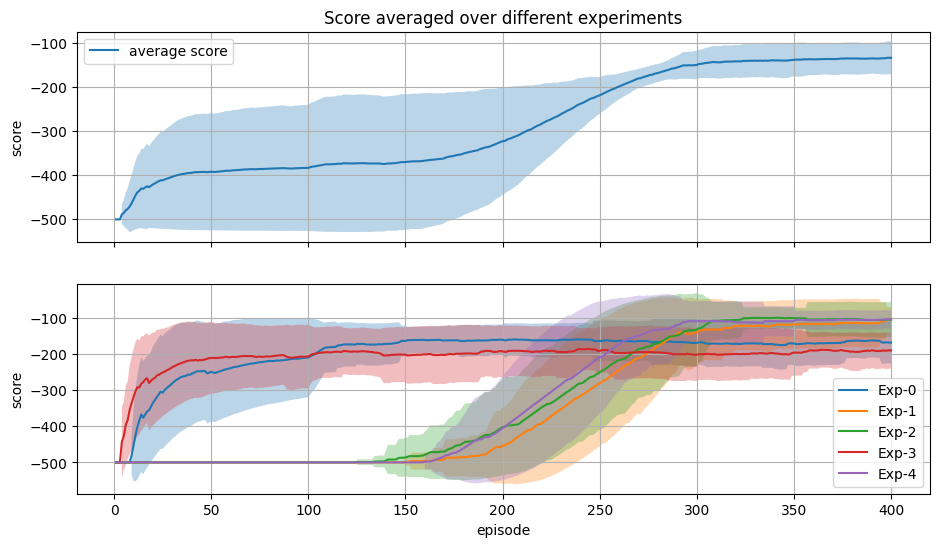

In [17]:
results_data_dict["Q-Learning (no Buffer)"] = [avg_scores, std_scores]
plot_results(avg_scores, std_scores)

The goal in the Acrobot environment is to minimize a cumulative negative penalty, which is given for every state when the tip of the double-pendulum is below some threshold. We see that the Q-Learning algorithm, although able to learn some useful behavior, has a lot of variance in terms of learning. On the other hand, we did not put a lot of effort in tuning the model hyperparameters, which could also explain the mediocre performance.

## Adding a Replay Buffer

Next, we add a replay buffer to the Q-Learning agent. Although training with PyTorch, which uses Tensor objects, it is simpler and more convenient to code the replay-buffer using Numpy.

In [20]:
class ReplayBuffer:
    def __init__(self, memory_size, observation_dim):
        self.observation_dim = observation_dim
        self.memory_size = memory_size
        self.ptr = 0
        self.is_full = False
        
        self.observations = None
        self.actions = None
        self.rewards = None
        self.next_observations = None
        self.terminates = None
        
    def reset(self):
        print("reset buffer...")
        self.observations = np.zeros((self.memory_size, self.observation_dim), dtype=np.float32)
        self.actions = np.zeros((self.memory_size, 1), dtype=int)
        self.rewards = np.zeros((self.memory_size, 1), dtype=np.float32)
        self.next_observations = np.zeros((self.memory_size, self.observation_dim), dtype=np.float32)
        self.terminates = np.zeros((self.memory_size, 1), dtype=bool)
        self.ptr = 0
    
    def store_transition(self, observation, action, reward, next_observation, terminated):
        self.observations[self.ptr] = observation
        self.actions[self.ptr] = action
        self.rewards[self.ptr] = reward
        self.next_observations[self.ptr] = next_observation
        self.terminates[self.ptr] = terminated
        
        self.ptr = (self.ptr + 1) % self.memory_size
        if self.ptr==0 and not self.is_full:
            self.is_full = True
            print("buffer is full...")
    
    def load_transition(self, batch_size=1):
        upper = self.memory_size if self.is_full else self.ptr
        samples = np.random.choice(upper, size=batch_size)
        return (self.observations[samples], self.actions[samples], self.rewards[samples], 
                self.next_observations[samples], self.terminates[samples])
    

Next, we make a few little adjustments to the original Q-Learning agent, for it to be compatible with the replay-buffer component. We add a `store_transition` and `load_batch` functions, that saves the experience into the replay-buffer's memory and loads a batch of transitions from the replay-buffer for training the Q-network respectively.

In [21]:
class QLearningAgentWithBuffer:
    def __init__(self, observation_dim, action_dim, n_actions, 
                 learning_rate, gamma, epsilon, epsilon_dec, epsilon_min, 
                 memory_size):
        super(QLearningAgentWithBuffer, self).__init__()
        self.observation_dim = observation_dim
        self.action_dim = action_dim
        self.n_actions = n_actions
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_dec = epsilon_dec
        self.epsilon_min = epsilon_min
        self.memory_size = memory_size
        self.learning_steps = 0
        
        # initialize a q network
        self.q = QNetwork(observation_dim, n_actions, learning_rate)
        
        # initialize a replay buffer
        self.replay_buffer = ReplayBuffer(memory_size, observation_dim)
        self.replay_buffer.reset()
        
    def choose_action(self, observation, evaluate=False):
        observation = T.from_numpy(observation).float().to(self.q.device)
        if evaluate:
            q_values = self.q(observation)
            action = T.argmax(q_values).item()
        else:
            if np.random.rand() < self.epsilon:
                action = np.random.randint(low=0, high=self.n_actions, size=1)[0]
            else:
                q_values = self.q(observation)
                action = T.argmax(q_values).item()
        return action
                
    
    def decrement_epsilon(self):
        self.epsilon = np.max([self.epsilon - self.epsilon_dec, self.epsilon_min])
        
    def store_transition(self, observation, action, reward, next_observation, terminated):
        self.replay_buffer.store_transition(observation, action, reward, next_observation, terminated)
        
    def load_batch(self, batch_size=1):
        return self.replay_buffer.load_transition(batch_size) 
        
    
    def learn(self, batch_size=1):
        self.learning_steps += 1
        if self.learning_steps <= batch_size:
            return
        
        # load batch from buffer
        observation, action, reward, next_observation, terminated = self.load_batch(batch_size)
        
        
        # send the transition to the device
        observation = T.from_numpy(observation).float().to(self.q.device)
        action = T.from_numpy(action).int().view(-1).to(self.q.device)
        reward = T.tensor(reward).float().view(-1).to(self.q.device)
        next_observation = T.from_numpy(next_observation).float().to(self.q.device)
        terminated = T.from_numpy(terminated).bool().view(-1).to(self.q.device)
        
        # compute the q_values
        indices = T.arange(batch_size)
        q_value = self.q(observation)[indices, action]
        next_q_value = T.max(self.q(next_observation), dim=1)[0] # take only the zero element which are the max values
        next_q_value[terminated] = 0.0  # set terminal state values to zero by hand
        
        # compute the target
        target = (reward + self.gamma * next_q_value).to(self.q.device)
        
        # compute the loss and backpropagate
        self.q.optimizer.zero_grad()
        q_loss = F.mse_loss(q_value, target)
        q_loss.backward()
        self.q.optimizer.step()
        
        # decrement epsilon
        self.decrement_epsilon()
    

Finally, we can run a few experiments. We use similar values for the hyperparameters as in the original Q-Learning experiment, just to have some common ground for comparison. However, you should keep in mind that it is not really a fair play because training with and without a buffer are two totally different frameworks, which results in different learning dynamics (the agent with buffer experience almost $8$ times more learning step). 

In [24]:
env = gym.make('Acrobot-v1')
scores = []
avg_scores = []
std_scores = []
epsilons = []

N_EXPERIMENTS = 5
N_EPISODES = 400
MAX_STEPS = 600
GAMMA = 0.99
LR = 5e-5
EPSILON = 1.
EPSILON_MIN = 0.001
EPSILON_DEC = (EPSILON - EPSILON_MIN) / (N_EPISODES * 0.2)
OBSERVATION_DIM = env.observation_space.shape[0]
ACTION_DIM = 1
N_ACTIONS = env.action_space.n
MEMORY_SIZE = 100000
BATCH_SIZE = 8

# run the experiments
for ex_i in range(N_EXPERIMENTS):
    scores.append([])
    avg_scores.append([])
    std_scores.append([])
    epsilons.append([])
    
    # init the agent
    agent = QLearningAgentWithBuffer(observation_dim=OBSERVATION_DIM, action_dim=ACTION_DIM, n_actions=N_ACTIONS, 
                                     learning_rate=LR, gamma=GAMMA, epsilon=EPSILON, epsilon_dec=EPSILON_DEC, 
                                     epsilon_min=EPSILON_MIN, memory_size=MEMORY_SIZE)
    # run the episodes for each experiment
    for ep_i in range(N_EPISODES):
        observation, info = env.reset()
        score = 0
        step = 0
        done = False

        while not done:
            step += 1
            epsilons[ex_i].append(agent.epsilon)
            action = agent.choose_action(observation)
            next_observation, reward, terminated, truncated, info = env.step(action)
            score += reward
            
            # store transition
            agent.store_transition(observation, action, reward, next_observation, terminated)
            
            # train the agent
            agent.learn(batch_size=BATCH_SIZE)
            
            # set next states to current states
            observation = next_observation
            
            # check for end of episode
            if terminated or truncated or step==MAX_STEPS:
                done = True
                scores[ex_i].append(score)
                avg_scores[ex_i].append(np.mean(scores[ex_i][-100:]))
                std_scores[ex_i].append(np.std(scores[ex_i][-100:]))
            
        print(f'| Experiment: {ex_i + 1:4} | Episode: {ep_i:4} | Score: {np.round(score, 2):2.3f}' + \
              f'| Avg score: {np.round(avg_scores[ex_i][-1], 2):2.3f} |')
env.close()

reset buffer...
| Experiment:    1 | Episode:    0 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:    1 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:    2 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:    3 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:    4 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:    5 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:    6 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:    7 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:    8 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:    9 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:   10 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:   11 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:   12 | Score: -500.000| Avg score: -500.00

| Experiment:    1 | Episode:  112 | Score: -162.000| Avg score: -183.030 |
| Experiment:    1 | Episode:  113 | Score: -75.000| Avg score: -178.780 |
| Experiment:    1 | Episode:  114 | Score: -83.000| Avg score: -174.610 |
| Experiment:    1 | Episode:  115 | Score: -130.000| Avg score: -170.910 |
| Experiment:    1 | Episode:  116 | Score: -85.000| Avg score: -166.760 |
| Experiment:    1 | Episode:  117 | Score: -96.000| Avg score: -162.720 |
| Experiment:    1 | Episode:  118 | Score: -89.000| Avg score: -158.610 |
| Experiment:    1 | Episode:  119 | Score: -76.000| Avg score: -154.370 |
| Experiment:    1 | Episode:  120 | Score: -112.000| Avg score: -150.490 |
| Experiment:    1 | Episode:  121 | Score: -104.000| Avg score: -146.530 |
| Experiment:    1 | Episode:  122 | Score: -134.000| Avg score: -142.870 |
| Experiment:    1 | Episode:  123 | Score: -100.000| Avg score: -138.870 |
| Experiment:    1 | Episode:  124 | Score: -149.000| Avg score: -135.360 |
| Experiment:    1

| Experiment:    1 | Episode:  222 | Score: -116.000| Avg score: -265.060 |
| Experiment:    1 | Episode:  223 | Score: -92.000| Avg score: -264.980 |
| Experiment:    1 | Episode:  224 | Score: -106.000| Avg score: -264.550 |
| Experiment:    1 | Episode:  225 | Score: -137.000| Avg score: -264.960 |
| Experiment:    1 | Episode:  226 | Score: -142.000| Avg score: -265.620 |
| Experiment:    1 | Episode:  227 | Score: -136.000| Avg score: -265.920 |
| Experiment:    1 | Episode:  228 | Score: -500.000| Avg score: -269.790 |
| Experiment:    1 | Episode:  229 | Score: -116.000| Avg score: -269.840 |
| Experiment:    1 | Episode:  230 | Score: -144.000| Avg score: -269.790 |
| Experiment:    1 | Episode:  231 | Score: -154.000| Avg score: -270.170 |
| Experiment:    1 | Episode:  232 | Score: -116.000| Avg score: -270.170 |
| Experiment:    1 | Episode:  233 | Score: -127.000| Avg score: -270.290 |
| Experiment:    1 | Episode:  234 | Score: -91.000| Avg score: -269.900 |
| Experiment: 

| Experiment:    1 | Episode:  331 | Score: -183.000| Avg score: -345.810 |
| Experiment:    1 | Episode:  332 | Score: -119.000| Avg score: -345.840 |
| Experiment:    1 | Episode:  333 | Score: -131.000| Avg score: -345.880 |
| Experiment:    1 | Episode:  334 | Score: -107.000| Avg score: -346.040 |
| Experiment:    1 | Episode:  335 | Score: -123.000| Avg score: -345.490 |
| Experiment:    1 | Episode:  336 | Score: -142.000| Avg score: -341.910 |
| Experiment:    1 | Episode:  337 | Score: -227.000| Avg score: -342.690 |
| Experiment:    1 | Episode:  338 | Score: -172.000| Avg score: -343.110 |
| Experiment:    1 | Episode:  339 | Score: -155.000| Avg score: -343.000 |
| Experiment:    1 | Episode:  340 | Score: -152.000| Avg score: -343.080 |
| Experiment:    1 | Episode:  341 | Score: -158.000| Avg score: -339.660 |
| Experiment:    1 | Episode:  342 | Score: -139.000| Avg score: -339.010 |
| Experiment:    1 | Episode:  343 | Score: -150.000| Avg score: -338.750 |
| Experiment

| Experiment:    2 | Episode:   40 | Score: -152.000| Avg score: -378.540 |
| Experiment:    2 | Episode:   41 | Score: -122.000| Avg score: -372.430 |
| Experiment:    2 | Episode:   42 | Score: -129.000| Avg score: -366.770 |
| Experiment:    2 | Episode:   43 | Score: -154.000| Avg score: -361.930 |
| Experiment:    2 | Episode:   44 | Score: -227.000| Avg score: -358.930 |
| Experiment:    2 | Episode:   45 | Score: -170.000| Avg score: -354.830 |
| Experiment:    2 | Episode:   46 | Score: -182.000| Avg score: -351.150 |
| Experiment:    2 | Episode:   47 | Score: -152.000| Avg score: -347.000 |
| Experiment:    2 | Episode:   48 | Score: -132.000| Avg score: -342.610 |
| Experiment:    2 | Episode:   49 | Score: -153.000| Avg score: -338.820 |
| Experiment:    2 | Episode:   50 | Score: -148.000| Avg score: -335.080 |
| Experiment:    2 | Episode:   51 | Score: -160.000| Avg score: -331.710 |
| Experiment:    2 | Episode:   52 | Score: -183.000| Avg score: -328.910 |
| Experiment

| Experiment:    2 | Episode:  149 | Score: -117.000| Avg score: -108.510 |
| Experiment:    2 | Episode:  150 | Score: -254.000| Avg score: -109.570 |
| Experiment:    2 | Episode:  151 | Score: -100.000| Avg score: -108.970 |
| Experiment:    2 | Episode:  152 | Score: -88.000| Avg score: -108.020 |
| Experiment:    2 | Episode:  153 | Score: -96.000| Avg score: -107.430 |
| Experiment:    2 | Episode:  154 | Score: -159.000| Avg score: -107.450 |
| Experiment:    2 | Episode:  155 | Score: -113.000| Avg score: -106.980 |
| Experiment:    2 | Episode:  156 | Score: -80.000| Avg score: -106.350 |
| Experiment:    2 | Episode:  157 | Score: -71.000| Avg score: -105.280 |
| Experiment:    2 | Episode:  158 | Score: -288.000| Avg score: -106.490 |
| Experiment:    2 | Episode:  159 | Score: -87.000| Avg score: -105.170 |
| Experiment:    2 | Episode:  160 | Score: -129.000| Avg score: -105.030 |
| Experiment:    2 | Episode:  161 | Score: -74.000| Avg score: -104.190 |
| Experiment:    2

| Experiment:    2 | Episode:  258 | Score: -128.000| Avg score: -349.150 |
| Experiment:    2 | Episode:  259 | Score: -144.000| Avg score: -349.720 |
| Experiment:    2 | Episode:  260 | Score: -238.000| Avg score: -350.810 |
| Experiment:    2 | Episode:  261 | Score: -120.000| Avg score: -351.270 |
| Experiment:    2 | Episode:  262 | Score: -151.000| Avg score: -351.890 |
| Experiment:    2 | Episode:  263 | Score: -149.000| Avg score: -351.940 |
| Experiment:    2 | Episode:  264 | Score: -124.000| Avg score: -352.260 |
| Experiment:    2 | Episode:  265 | Score: -133.000| Avg score: -352.510 |
| Experiment:    2 | Episode:  266 | Score: -144.000| Avg score: -353.130 |
| Experiment:    2 | Episode:  267 | Score: -170.000| Avg score: -353.720 |
| Experiment:    2 | Episode:  268 | Score: -147.000| Avg score: -352.940 |
| Experiment:    2 | Episode:  269 | Score: -134.000| Avg score: -352.970 |
| Experiment:    2 | Episode:  270 | Score: -193.000| Avg score: -354.010 |
| Experiment

| Experiment:    2 | Episode:  369 | Score: -138.000| Avg score: -110.560 |
| Experiment:    2 | Episode:  370 | Score: -143.000| Avg score: -110.060 |
| Experiment:    2 | Episode:  371 | Score: -196.000| Avg score: -110.890 |
| Experiment:    2 | Episode:  372 | Score: -157.000| Avg score: -111.260 |
| Experiment:    2 | Episode:  373 | Score: -219.000| Avg score: -112.740 |
| Experiment:    2 | Episode:  374 | Score: -117.000| Avg score: -112.680 |
| Experiment:    2 | Episode:  375 | Score: -148.000| Avg score: -112.050 |
| Experiment:    2 | Episode:  376 | Score: -190.000| Avg score: -112.640 |
| Experiment:    2 | Episode:  377 | Score: -117.000| Avg score: -112.800 |
| Experiment:    2 | Episode:  378 | Score: -500.000| Avg score: -116.920 |
| Experiment:    2 | Episode:  379 | Score: -500.000| Avg score: -121.010 |
| Experiment:    2 | Episode:  380 | Score: -427.000| Avg score: -124.150 |
| Experiment:    2 | Episode:  381 | Score: -500.000| Avg score: -128.010 |
| Experiment

| Experiment:    3 | Episode:   81 | Score: -125.000| Avg score: -223.770 |
| Experiment:    3 | Episode:   82 | Score: -106.000| Avg score: -222.350 |
| Experiment:    3 | Episode:   83 | Score: -88.000| Avg score: -220.750 |
| Experiment:    3 | Episode:   84 | Score: -79.000| Avg score: -219.080 |
| Experiment:    3 | Episode:   85 | Score: -84.000| Avg score: -217.510 |
| Experiment:    3 | Episode:   86 | Score: -77.000| Avg score: -215.900 |
| Experiment:    3 | Episode:   87 | Score: -81.000| Avg score: -214.360 |
| Experiment:    3 | Episode:   88 | Score: -94.000| Avg score: -213.010 |
| Experiment:    3 | Episode:   89 | Score: -92.000| Avg score: -211.670 |
| Experiment:    3 | Episode:   90 | Score: -79.000| Avg score: -210.210 |
| Experiment:    3 | Episode:   91 | Score: -86.000| Avg score: -208.860 |
| Experiment:    3 | Episode:   92 | Score: -87.000| Avg score: -207.550 |
| Experiment:    3 | Episode:   93 | Score: -88.000| Avg score: -206.280 |
| Experiment:    3 | Ep

| Experiment:    3 | Episode:  192 | Score: -117.000| Avg score: -191.380 |
| Experiment:    3 | Episode:  193 | Score: -138.000| Avg score: -191.880 |
| Experiment:    3 | Episode:  194 | Score: -99.000| Avg score: -192.080 |
| Experiment:    3 | Episode:  195 | Score: -130.000| Avg score: -192.470 |
| Experiment:    3 | Episode:  196 | Score: -128.000| Avg score: -192.810 |
| Experiment:    3 | Episode:  197 | Score: -107.000| Avg score: -192.700 |
| Experiment:    3 | Episode:  198 | Score: -93.000| Avg score: -192.820 |
| Experiment:    3 | Episode:  199 | Score: -119.000| Avg score: -193.020 |
| Experiment:    3 | Episode:  200 | Score: -129.000| Avg score: -193.510 |
| Experiment:    3 | Episode:  201 | Score: -99.000| Avg score: -193.500 |
| Experiment:    3 | Episode:  202 | Score: -97.000| Avg score: -193.440 |
| Experiment:    3 | Episode:  203 | Score: -112.000| Avg score: -193.720 |
| Experiment:    3 | Episode:  204 | Score: -104.000| Avg score: -193.860 |
| Experiment:   

| Experiment:    3 | Episode:  301 | Score: -163.000| Avg score: -296.950 |
| Experiment:    3 | Episode:  302 | Score: -201.000| Avg score: -297.990 |
| Experiment:    3 | Episode:  303 | Score: -154.000| Avg score: -298.410 |
| Experiment:    3 | Episode:  304 | Score: -355.000| Avg score: -300.920 |
| Experiment:    3 | Episode:  305 | Score: -186.000| Avg score: -301.790 |
| Experiment:    3 | Episode:  306 | Score: -142.000| Avg score: -301.920 |
| Experiment:    3 | Episode:  307 | Score: -125.000| Avg score: -301.640 |
| Experiment:    3 | Episode:  308 | Score: -221.000| Avg score: -302.870 |
| Experiment:    3 | Episode:  309 | Score: -243.000| Avg score: -304.360 |
| Experiment:    3 | Episode:  310 | Score: -127.000| Avg score: -304.810 |
| Experiment:    3 | Episode:  311 | Score: -176.000| Avg score: -305.540 |
| Experiment:    3 | Episode:  312 | Score: -111.000| Avg score: -305.550 |
| Experiment:    3 | Episode:  313 | Score: -135.000| Avg score: -305.920 |
| Experiment

| Experiment:    4 | Episode:    9 | Score: -500.000| Avg score: -500.000 |
| Experiment:    4 | Episode:   10 | Score: -500.000| Avg score: -500.000 |
| Experiment:    4 | Episode:   11 | Score: -500.000| Avg score: -500.000 |
| Experiment:    4 | Episode:   12 | Score: -500.000| Avg score: -500.000 |
| Experiment:    4 | Episode:   13 | Score: -500.000| Avg score: -500.000 |
| Experiment:    4 | Episode:   14 | Score: -500.000| Avg score: -500.000 |
| Experiment:    4 | Episode:   15 | Score: -500.000| Avg score: -500.000 |
| Experiment:    4 | Episode:   16 | Score: -500.000| Avg score: -500.000 |
| Experiment:    4 | Episode:   17 | Score: -500.000| Avg score: -500.000 |
| Experiment:    4 | Episode:   18 | Score: -500.000| Avg score: -500.000 |
| Experiment:    4 | Episode:   19 | Score: -500.000| Avg score: -500.000 |
| Experiment:    4 | Episode:   20 | Score: -500.000| Avg score: -500.000 |
| Experiment:    4 | Episode:   21 | Score: -446.000| Avg score: -497.550 |
| Experiment

| Experiment:    4 | Episode:  119 | Score: -77.000| Avg score: -164.370 |
| Experiment:    4 | Episode:  120 | Score: -93.000| Avg score: -160.300 |
| Experiment:    4 | Episode:  121 | Score: -77.000| Avg score: -156.610 |
| Experiment:    4 | Episode:  122 | Score: -91.000| Avg score: -152.520 |
| Experiment:    4 | Episode:  123 | Score: -86.000| Avg score: -148.380 |
| Experiment:    4 | Episode:  124 | Score: -90.000| Avg score: -144.280 |
| Experiment:    4 | Episode:  125 | Score: -86.000| Avg score: -140.140 |
| Experiment:    4 | Episode:  126 | Score: -81.000| Avg score: -135.950 |
| Experiment:    4 | Episode:  127 | Score: -83.000| Avg score: -131.780 |
| Experiment:    4 | Episode:  128 | Score: -89.000| Avg score: -127.670 |
| Experiment:    4 | Episode:  129 | Score: -93.000| Avg score: -123.600 |
| Experiment:    4 | Episode:  130 | Score: -94.000| Avg score: -119.540 |
| Experiment:    4 | Episode:  131 | Score: -86.000| Avg score: -117.520 |
| Experiment:    4 | Epis

| Experiment:    4 | Episode:  228 | Score: -140.000| Avg score: -174.930 |
| Experiment:    4 | Episode:  229 | Score: -131.000| Avg score: -175.310 |
| Experiment:    4 | Episode:  230 | Score: -85.000| Avg score: -175.220 |
| Experiment:    4 | Episode:  231 | Score: -192.000| Avg score: -176.280 |
| Experiment:    4 | Episode:  232 | Score: -500.000| Avg score: -180.510 |
| Experiment:    4 | Episode:  233 | Score: -112.000| Avg score: -180.770 |
| Experiment:    4 | Episode:  234 | Score: -194.000| Avg score: -181.880 |
| Experiment:    4 | Episode:  235 | Score: -112.000| Avg score: -181.910 |
| Experiment:    4 | Episode:  236 | Score: -85.000| Avg score: -181.970 |
| Experiment:    4 | Episode:  237 | Score: -97.000| Avg score: -181.950 |
| Experiment:    4 | Episode:  238 | Score: -136.000| Avg score: -182.440 |
| Experiment:    4 | Episode:  239 | Score: -96.000| Avg score: -182.490 |
| Experiment:    4 | Episode:  240 | Score: -189.000| Avg score: -183.290 |
| Experiment:   

| Experiment:    4 | Episode:  337 | Score: -177.000| Avg score: -315.010 |
| Experiment:    4 | Episode:  338 | Score: -172.000| Avg score: -315.370 |
| Experiment:    4 | Episode:  339 | Score: -135.000| Avg score: -315.760 |
| Experiment:    4 | Episode:  340 | Score: -155.000| Avg score: -315.420 |
| Experiment:    4 | Episode:  341 | Score: -107.000| Avg score: -315.720 |
| Experiment:    4 | Episode:  342 | Score: -150.000| Avg score: -316.290 |
| Experiment:    4 | Episode:  343 | Score: -143.000| Avg score: -316.800 |
| Experiment:    4 | Episode:  344 | Score: -127.000| Avg score: -316.960 |
| Experiment:    4 | Episode:  345 | Score: -138.000| Avg score: -313.930 |
| Experiment:    4 | Episode:  346 | Score: -180.000| Avg score: -314.000 |
| Experiment:    4 | Episode:  347 | Score: -205.000| Avg score: -314.910 |
| Experiment:    4 | Episode:  348 | Score: -133.000| Avg score: -315.310 |
| Experiment:    4 | Episode:  349 | Score: -131.000| Avg score: -314.860 |
| Experiment

| Experiment:    5 | Episode:   47 | Score: -128.000| Avg score: -355.850 |
| Experiment:    5 | Episode:   48 | Score: -140.000| Avg score: -351.450 |
| Experiment:    5 | Episode:   49 | Score: -157.000| Avg score: -347.560 |
| Experiment:    5 | Episode:   50 | Score: -124.000| Avg score: -343.180 |
| Experiment:    5 | Episode:   51 | Score: -122.000| Avg score: -338.920 |
| Experiment:    5 | Episode:   52 | Score: -150.000| Avg score: -335.360 |
| Experiment:    5 | Episode:   53 | Score: -151.000| Avg score: -331.940 |
| Experiment:    5 | Episode:   54 | Score: -138.000| Avg score: -328.420 |
| Experiment:    5 | Episode:   55 | Score: -206.000| Avg score: -326.230 |
| Experiment:    5 | Episode:   56 | Score: -123.000| Avg score: -322.670 |
| Experiment:    5 | Episode:   57 | Score: -186.000| Avg score: -320.310 |
| Experiment:    5 | Episode:   58 | Score: -167.000| Avg score: -317.710 |
| Experiment:    5 | Episode:   59 | Score: -141.000| Avg score: -314.770 |
| Experiment

| Experiment:    5 | Episode:  157 | Score: -82.000| Avg score: -196.550 |
| Experiment:    5 | Episode:  158 | Score: -94.000| Avg score: -195.820 |
| Experiment:    5 | Episode:  159 | Score: -92.000| Avg score: -195.330 |
| Experiment:    5 | Episode:  160 | Score: -116.000| Avg score: -193.590 |
| Experiment:    5 | Episode:  161 | Score: -114.000| Avg score: -192.750 |
| Experiment:    5 | Episode:  162 | Score: -116.000| Avg score: -191.520 |
| Experiment:    5 | Episode:  163 | Score: -75.000| Avg score: -190.570 |
| Experiment:    5 | Episode:  164 | Score: -91.000| Avg score: -189.800 |
| Experiment:    5 | Episode:  165 | Score: -128.000| Avg score: -189.170 |
| Experiment:    5 | Episode:  166 | Score: -105.000| Avg score: -188.660 |
| Experiment:    5 | Episode:  167 | Score: -141.000| Avg score: -188.540 |
| Experiment:    5 | Episode:  168 | Score: -99.000| Avg score: -188.170 |
| Experiment:    5 | Episode:  169 | Score: -111.000| Avg score: -187.560 |
| Experiment:    5

| Experiment:    5 | Episode:  266 | Score: -88.000| Avg score: -215.840 |
| Experiment:    5 | Episode:  267 | Score: -103.000| Avg score: -215.460 |
| Experiment:    5 | Episode:  268 | Score: -70.000| Avg score: -215.170 |
| Experiment:    5 | Episode:  269 | Score: -71.000| Avg score: -214.770 |
| Experiment:    5 | Episode:  270 | Score: -64.000| Avg score: -214.630 |
| Experiment:    5 | Episode:  271 | Score: -90.000| Avg score: -214.470 |
| Experiment:    5 | Episode:  272 | Score: -165.000| Avg score: -215.210 |
| Experiment:    5 | Episode:  273 | Score: -69.000| Avg score: -215.120 |
| Experiment:    5 | Episode:  274 | Score: -97.000| Avg score: -215.310 |
| Experiment:    5 | Episode:  275 | Score: -108.000| Avg score: -213.480 |
| Experiment:    5 | Episode:  276 | Score: -77.000| Avg score: -213.080 |
| Experiment:    5 | Episode:  277 | Score: -84.000| Avg score: -212.360 |
| Experiment:    5 | Episode:  278 | Score: -69.000| Avg score: -211.790 |
| Experiment:    5 | E

| Experiment:    5 | Episode:  376 | Score: -109.000| Avg score: -85.950 |
| Experiment:    5 | Episode:  377 | Score: -77.000| Avg score: -85.880 |
| Experiment:    5 | Episode:  378 | Score: -94.000| Avg score: -86.130 |
| Experiment:    5 | Episode:  379 | Score: -269.000| Avg score: -88.030 |
| Experiment:    5 | Episode:  380 | Score: -95.000| Avg score: -88.290 |
| Experiment:    5 | Episode:  381 | Score: -78.000| Avg score: -88.430 |
| Experiment:    5 | Episode:  382 | Score: -63.000| Avg score: -87.990 |
| Experiment:    5 | Episode:  383 | Score: -83.000| Avg score: -87.080 |
| Experiment:    5 | Episode:  384 | Score: -89.000| Avg score: -86.450 |
| Experiment:    5 | Episode:  385 | Score: -172.000| Avg score: -87.220 |
| Experiment:    5 | Episode:  386 | Score: -92.000| Avg score: -87.450 |
| Experiment:    5 | Episode:  387 | Score: -93.000| Avg score: -87.500 |
| Experiment:    5 | Episode:  388 | Score: -94.000| Avg score: -87.610 |
| Experiment:    5 | Episode:  389 

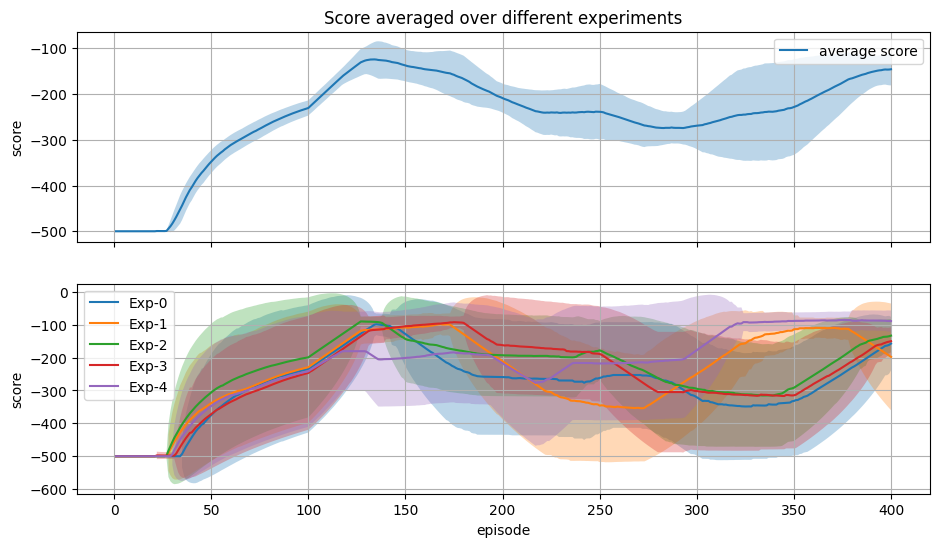

In [25]:
results_data_dict["Q-Learning (with Buffer)"] = [avg_scores, std_scores]
plot_results(avg_scores, std_scores)

We see that Q-Learning with a replay-buffer learns quicker and results in a set of a bit nicer learning curves and smaller variance than the original Q-Learning implementation.

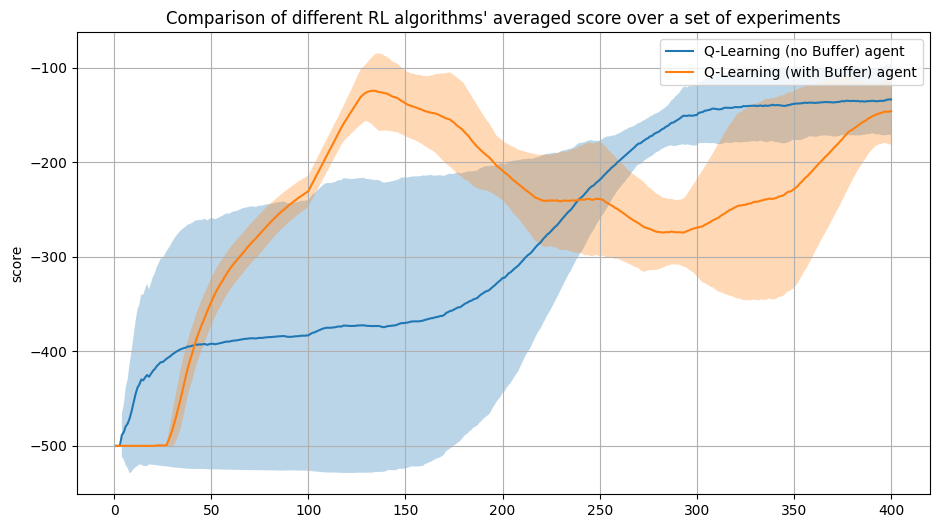

In [26]:
compare_results(results_data_dict)

## Conclusion

We have implemented two variations of the off-polcy RL algorithm Q-Learning (with a neural network), with and without an experience replay buffer.  The experience replay buffer addition to the algorithms improves a bit the learning process in terms of stability, repeatability (between experiments), lower variance, and quicker learning. These are mostly due to the decorrelation of transitions used in the learning process, which arise when using a buffer (we sample transitions randomly from the buffer, which for large buffers results in batches uncorrelated of transitions). 

## References
- [1] Sutton & Barto - Reinforcement Learning An Introduction Second edition (2018)
- [2] Long-Ji Lin - Self-Improving Reactive Agents Based On Reinforcement Learning, Planning and Teaching (1992)
- [3] Shangtong Zhang, Richard S. Sutton - A Deeper Look at Experience Replay (2018)

## Contact
If you have any comments, corrections or questions about the material presented in the notebook, please do not hesitate to email me at elkabetz.roy@gmail.com